In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split # type: ignore
import matplotlib.pyplot as plt # type: ignore

In [2]:
# Get current working directory
import os
cwd = os.getcwd()
print("Current working directory:", cwd)
os.chdir("n:/Incubator2025_ComputationalLifeCourse")

Current working directory: n:\Incubator2025_ComputationalLifeCourse\Scripts\g_comp


In [3]:
import sys
sys.path.append("Scripts/g_comp")  # relative path from your current working directory
import g_comp as gc

In [4]:
# Reload the module (if it's been edited and needs to be reloaded)
import importlib
importlib.reload(gc)

<module 'g_comp' from 'n:\\Incubator2025_ComputationalLifeCourse\\Scripts/g_comp\\g_comp.py'>

In [5]:
def set_seed(seed =42):
    """Set seed for reproducibility across multiple libraries"""
    random.seed(seed)  # Python's built-in random
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch
    torch.cuda.manual_seed_all(seed)  # PyTorch CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(2025)  # Call this at the beginning of your code

In [6]:
## Load the data 
import pandas as pd
df = pd.read_csv("Data/Processed/g_data.csv")
df = df.sort_values(["mergeid", "t_age"]) 

In [7]:
## Check the number of dropped cases 
complete_y_depress_65_75_dic_mergeids = gc.summarize_mergeid_completeness(df, ["y_depress_65_75_dic", "dt_n_years_disease_dic"], "depress 65–75")

[depress 65–75]
Original mergeids: 20806
Complete mergeids (no missing values in Y): 14598
Number of unique mergeids dropped: 6208



In [8]:
###############
## Data prep ##
###############

# N = number of individuals, T = number of time points (i.e., 33)
# Generate datasets for pooled and by regime 
T = 33
df_depress_65_75 = gc.get_valid_df(df, complete_y_depress_65_75_dic_mergeids, "depress 65–75", T)
df_depress_med_65_75 = df_depress_65_75[df_depress_65_75["mod_welfare_regime_mediterranean"] == 1.0]
df_depress_cor_65_75 = df_depress_65_75[df_depress_65_75["mod_welfare_regime_corporatist"] == 1.0]
df_depress_scan_65_75 = df_depress_65_75[df_depress_65_75["mod_welfare_regime_scandinavian"] == 1.0]
 

# Mediterranean 
feature_cols_outcome_med_65_75 = gc.get_feature_cols(df_depress_med_65_75, context="outcome and med")
feature_cols_tv_covar_med_65_75 = gc.get_feature_cols(df_depress_med_65_75, context="tv_covar and med")

# Corporatist
feature_cols_outcome_cor_65_75 = gc.get_feature_cols(df_depress_cor_65_75, context="outcome and cor")
feature_cols_tv_covar_cor_65_75 = gc.get_feature_cols(df_depress_cor_65_75, context="tv_covar and cor")

# Scandinavian
feature_cols_outcome_scan_65_75 = gc.get_feature_cols(df_depress_scan_65_75, context="outcome and scan")
feature_cols_tv_covar_scan_65_75 = gc.get_feature_cols(df_depress_scan_65_75, context="tv_covar and scan")


# Convert to (N, T, D) tensor
# Treatment and covariates from the dataset 
 
# Mediterranean 
N_depress_med_65_75 = df_depress_med_65_75['mergeid'].nunique()
X_depress_med_65_75 = gc.convert_df_to_X(df_depress_med_65_75, feature_cols_outcome_med_65_75, N_depress_med_65_75, T)
X_disease_med_65_75  = gc.convert_df_to_X(df_depress_med_65_75, feature_cols_tv_covar_med_65_75, N_depress_med_65_75, T)

# Corporatist
N_depress_cor_65_75 = df_depress_cor_65_75['mergeid'].nunique()
X_depress_cor_65_75 = gc.convert_df_to_X(df_depress_cor_65_75, feature_cols_outcome_cor_65_75, N_depress_cor_65_75, T)
X_disease_cor_65_75  = gc.convert_df_to_X(df_depress_cor_65_75, feature_cols_tv_covar_cor_65_75, N_depress_cor_65_75, T)

# Scandinavian
N_depress_scan_65_75 = df_depress_scan_65_75['mergeid'].nunique()
X_depress_scan_65_75 = gc.convert_df_to_X(df_depress_scan_65_75, feature_cols_outcome_scan_65_75, N_depress_scan_65_75, T)
X_disease_scan_65_75  = gc.convert_df_to_X(df_depress_scan_65_75, feature_cols_tv_covar_scan_65_75, N_depress_scan_65_75, T)

[depress 65–75]
Mergeids with complete outcome and 33 unique ages: 14598
[get_feature_cols] Context: outcome and med | Exclude: ['mod_country_italy']
⚠️ dt_n_years_disease_dic IS STILL INCLUDED
[get_feature_cols] Context: tv_covar and med | Exclude: ['mod_country_italy', 'dt_n_years_disease_dic']
✅ dt_n_years_disease_dic successfully excluded
[get_feature_cols] Context: outcome and cor | Exclude: ['mod_country_germany']
⚠️ dt_n_years_disease_dic IS STILL INCLUDED
[get_feature_cols] Context: tv_covar and cor | Exclude: ['mod_country_germany', 'dt_n_years_disease_dic']
✅ dt_n_years_disease_dic successfully excluded
[get_feature_cols] Context: outcome and scan | Exclude: ['mod_country_sweden']
⚠️ dt_n_years_disease_dic IS STILL INCLUDED
[get_feature_cols] Context: tv_covar and scan | Exclude: ['mod_country_sweden', 'dt_n_years_disease_dic']
✅ dt_n_years_disease_dic successfully excluded


In [9]:
###############
## Y and L_t ##
###############

# Binary outcomes  
y_depress_med_65_75_dic = gc.extract_y_tensor(df_depress_med_65_75, "y_depress_65_75_dic")
y_depress_cor_65_75_dic = gc.extract_y_tensor(df_depress_cor_65_75, "y_depress_65_75_dic")
y_depress_scan_65_75_dic = gc.extract_y_tensor(df_depress_scan_65_75, "y_depress_65_75_dic")

# Binary outcomes for tv covar 
# Mediterranean 
y_depress_disease_med_65_75_dic = gc.extract_y_tensor(df_depress_med_65_75, "dt_n_years_disease_dic")
y_depress_disease_cor_65_75_dic = gc.extract_y_tensor(df_depress_cor_65_75, "dt_n_years_disease_dic")
y_depress_disease_scan_65_75_dic = gc.extract_y_tensor(df_depress_scan_65_75, "dt_n_years_disease_dic")

In [10]:
#####################
## \vec{a} and L_0 ##
#####################

# Extract high-level treatment trajectory features with covariates for each X matrix
# Mediterranean
X_med_features_depress_65_75_dic = gc.extract_features(X_depress_med_65_75, feature_cols_outcome_med_65_75)
X_med_features_disease_65_75_dic  = gc.extract_features(X_disease_med_65_75, feature_cols_tv_covar_med_65_75)

# Corporatist
X_cor_features_depress_65_75_dic = gc.extract_features(X_depress_cor_65_75, feature_cols_outcome_cor_65_75)
X_cor_features_disease_65_75_dic  = gc.extract_features(X_disease_cor_65_75, feature_cols_tv_covar_cor_65_75)

# Scandinavian
X_scan_features_depress_65_75_dic = gc.extract_features(X_depress_scan_65_75, feature_cols_outcome_scan_65_75)
X_scan_features_disease_65_75_dic  = gc.extract_features(X_disease_scan_65_75, feature_cols_tv_covar_scan_65_75)



# Feature Names
trt_features_med_depress_65_75_dic   = gc.create_feature_df(X_med_features_depress_65_75_dic, feature_cols_outcome_med_65_75, "depress 65–75")
trt_features_cor_depress_65_75_dic   = gc.create_feature_df(X_cor_features_depress_65_75_dic, feature_cols_outcome_cor_65_75, "depress 65–75")
trt_features_scan_depress_65_75_dic   = gc.create_feature_df(X_scan_features_depress_65_75_dic, feature_cols_outcome_scan_65_75, "depress 65–75")


depress 65–75: Feature dataframe shape = (4589, 48)
depress 65–75: Feature dataframe shape = (7273, 48)
depress 65–75: Feature dataframe shape = (2736, 48)


In [11]:
################### 
## Linear models ##
#################### 

y_depress_med_65_75_dic_logistic = gc.train_and_evaluate_logistic(X_med_features_depress_65_75_dic, y_depress_med_65_75_dic, "depress 65–75 (med, logistic)", save_dir="model_outputs/depress/med")
y_disease_med_65_75_dic_logistic = gc.train_and_evaluate_logistic(X_med_features_disease_65_75_dic, y_depress_disease_med_65_75_dic, "disease 65–75 (med, logistic)", save_dir="model_outputs/depress/med")

y_depress_cor_65_75_dic_logistic = gc.train_and_evaluate_logistic(X_cor_features_depress_65_75_dic, y_depress_cor_65_75_dic, "depress 65–75 (cor, logistic)", save_dir="model_outputs/depress/cor")
y_disease_cor_65_75_dic_logistic = gc.train_and_evaluate_logistic(X_cor_features_disease_65_75_dic, y_depress_disease_cor_65_75_dic, "disease 65–75 (cor, logistic)", save_dir="model_outputs/depress/cor")

y_depress_scan_65_75_dic_logistic = gc.train_and_evaluate_logistic(X_scan_features_depress_65_75_dic, y_depress_scan_65_75_dic, "depress 65–75 (scan, logistic)", save_dir="model_outputs/depress/scan")
y_disease_scan_65_75_dic_logistic = gc.train_and_evaluate_logistic(X_scan_features_disease_65_75_dic, y_depress_disease_scan_65_75_dic, "disease 65–75 (scan, logistic)", save_dir="model_outputs/depress/scan")


=== depress 65–75 (med, logistic) ===
Train Accuracy: 0.6335616438356164
Test Accuracy: 0.6376180101670298
Test AUC: 0.6748281665773416

=== disease 65–75 (med, logistic) ===
Train Accuracy: 0.5974470734744707
Test Accuracy: 0.579520697167756
Test AUC: 0.6059072289956142

=== depress 65–75 (cor, logistic) ===
Train Accuracy: 0.6344529561972108
Test Accuracy: 0.6196150320806599
Test AUC: 0.6301597485010354

=== disease 65–75 (cor, logistic) ===
Train Accuracy: 0.6197210764093498
Test Accuracy: 0.5989917506874427
Test AUC: 0.5975707128692204

=== depress 65–75 (scan, logistic) ===
Train Accuracy: 0.6741514360313315
Test Accuracy: 0.6285018270401949
Test AUC: 0.6388109453785944

=== disease 65–75 (scan, logistic) ===
Train Accuracy: 0.6678851174934726
Test Accuracy: 0.6065773447015834
Test AUC: 0.6106308991554893


In [12]:
# Logistic regression coefficients 
y_depress_med_65_75_logistic_coef_summary = gc.logistic_coef_summary(
    y_depress_med_65_75_dic_logistic,
    trt_features_med_depress_65_75_dic,
    y_depress_med_65_75_dic,
    label="y_depress_med_65_75_dic_logistic",   # this will be used for the file name
    save_dir="model_outputs/depress/med"
)

y_depress_cor_65_75_logistic_coef_summary = gc.logistic_coef_summary(
    y_depress_cor_65_75_dic_logistic,
    trt_features_cor_depress_65_75_dic,
    y_depress_med_65_75_dic,
    label="y_depress_cor_65_75_dic_logistic",   # this will be used for the file name
    save_dir="model_outputs/depress/cor"
)

y_depress_scan_65_75_logistic_coef_summary = gc.logistic_coef_summary(
    y_depress_scan_65_75_dic_logistic,
    trt_features_scan_depress_65_75_dic,
    y_depress_scan_65_75_dic,
    label="y_depress_scan_65_75_dic_logistic",   # this will be used for the file name
    save_dir="model_outputs/depress/scan"
)

print(y_depress_med_65_75_logistic_coef_summary)
print(y_depress_cor_65_75_logistic_coef_summary)
print(y_depress_scan_65_75_logistic_coef_summary)

c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
n:\Incubator2025_ComputationalLifeCourse\Scripts/g_comp\g_comp.py:542: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(cov_logit))
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


✅ Saved coefficient summary to: model_outputs/depress/med\y_depress_med_65_75_dic_logistic_coef_summary.csv
✅ Saved coefficient summary to: model_outputs/depress/cor\y_depress_cor_65_75_dic_logistic_coef_summary.csv
✅ Saved coefficient summary to: model_outputs/depress/scan\y_depress_scan_65_75_dic_logistic_coef_summary.csv
                      feature      coef  odds_ratio     std_error  \
0                   Intercept -0.072748    0.929835           NaN   
1               cum_full_time  0.137967    1.147938  1.343729e-01   
2               cum_part_time  0.104586    1.110251  8.616085e-02   
3                 years_cohab -0.033103    0.967439           NaN   
4             years_not_cohab  0.033103    1.033657           NaN   
5         years_with_children  0.053715    1.055184           NaN   
6      years_without_children -0.053715    0.947702           NaN   
7     dominant_work_full_time -0.075465    0.927313           NaN   
8     dominant_work_part_time -0.116194    0.890302  

n:\Incubator2025_ComputationalLifeCourse\Scripts/g_comp\g_comp.py:542: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(cov_logit))
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
n:\Incubator2025_ComputationalLifeCourse\Scripts/g_comp\g_comp.py:542: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(cov_logit))


In [13]:
############################
## Tuning for best models ##
############################
# Best models for med sample 
y_depress_med_65_75_dic_model, y_depress_med_65_75_dic_best_models = gc.train_and_evaluate_with_tuning(X_med_features_depress_65_75_dic, y_depress_med_65_75_dic, "depress 65–75 (med)", save_dir="model_outputs/depress/med")
y_depress_disease_med_65_75_dic_model, y_depress_disease_med_65_75_dic_best_models = gc.train_and_evaluate_with_tuning(X_med_features_disease_65_75_dic, y_depress_disease_med_65_75_dic, "depress disease 65–75 (med)", save_dir="model_outputs/depress/med")

c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_


=== depress 65–75 (med) ===
Train Accuracy: 0.6986301369863014
Test Accuracy: 0.6347131445170661
Test AUC: 0.679334386430096


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:36:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:36:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:36:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encod


=== depress disease 65–75 (med) ===
Train Accuracy: 0.5809464508094645
Test Accuracy: 0.579520697167756
Test AUC: 0.615107110754511


In [14]:
# Best models for cor sample 
y_depress_cor_65_75_dic_model, y_depress_cor_65_75_dic_best_models = gc.train_and_evaluate_with_tuning(X_cor_features_depress_65_75_dic, y_depress_cor_65_75_dic, "depress 65–75 (cor)", save_dir="model_outputs/depress/cor")
y_depress_disease_cor_65_75_dic_model, y_depress_disease_cor_65_75_dic_best_models = gc.train_and_evaluate_with_tuning(X_cor_features_disease_65_75_dic, y_depress_disease_cor_65_75_dic, "depress disease 65–75 (cor)", save_dir="model_outputs/depress/cor")

c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:37:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:37:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:37:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encod


=== depress 65–75 (cor) ===
Train Accuracy: 0.6831663720290709
Test Accuracy: 0.6090742438130156
Test AUC: 0.6362585297740145


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:38:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\sr


=== depress disease 65–75 (cor) ===
Train Accuracy: 0.6228638774307602
Test Accuracy: 0.581576535288726
Test AUC: 0.6060249452040496


In [15]:
# Best models for scan sample 
y_depress_scan_65_75_dic_model, y_depress_scan_65_75_dic_best_models = gc.train_and_evaluate_with_tuning(X_scan_features_depress_65_75_dic, y_depress_scan_65_75_dic, "depress 65–75 (scan)", save_dir="model_outputs/depress/scan")
y_depress_disease_scan_65_75_dic_model, y_depress_disease_scan_65_75_dic_best_models = gc.train_and_evaluate_with_tuning(X_scan_features_disease_65_75_dic, y_depress_disease_scan_65_75_dic, "depress disease 65–75 (scan)", save_dir="model_outputs/depress/scan")

c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_


=== depress 65–75 (scan) ===
Train Accuracy: 0.6266318537859008
Test Accuracy: 0.5931790499390986
Test AUC: 0.6279773834891031


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_


=== depress disease 65–75 (scan) ===
Train Accuracy: 0.8114882506527415
Test Accuracy: 0.5968331303288672
Test AUC: 0.6218082463984103


In [16]:
#############################
## Counterfactual analysis ## 
#############################

import pandas as pd
# Load CSV
medoid_df = pd.read_csv("Data/Processed/medoid_seq_data.csv")

# Sort by cluster and t_age
medoid_df = medoid_df.sort_values(["cluster", "t_age"])

# Reorder columns so cluster is first
cols = ["cluster"] + [col for col in medoid_df.columns if col != "cluster"]
medoid_df = medoid_df[cols]

N_medoid = medoid_df['cluster'].nunique()
X_medoid_depress_65_75_dic   = gc.convert_df_to_X(medoid_df, feature_cols_outcome_med_65_75, N_medoid, T)
X_medoid_disease_65_75_dic  = gc.convert_df_to_X(medoid_df, feature_cols_tv_covar_med_65_75, N_medoid, T)
X_medoid_features_65_75_dic   = gc.extract_treatment_features_from_medoid(X_medoid_depress_65_75_dic, feature_cols_outcome_med_65_75) 

In [17]:
################################################# 
## refit the final model with all origina data ##
#################################################
 
 
# Mediterranean models
y_depress_med_final_models = gc.refit_and_save_final_models(
    X=X_med_features_depress_65_75_dic,
    y=y_depress_med_65_75_dic,
    base_models=y_depress_med_65_75_dic_best_models,
    label="depress 65–75 (med)",
    save=False
)

y_depress_disease_med_final_models = gc.refit_and_save_final_models(
    X=X_med_features_disease_65_75_dic,
    y=y_depress_disease_med_65_75_dic,
    base_models=y_depress_disease_med_65_75_dic_best_models,
    label="disease 65–75 (med)",
    save=False
)

y_depress_med_super_learner = gc.refit_and_save_super_learner(
    X=X_med_features_depress_65_75_dic,
    y=y_depress_med_65_75_dic,
    base_models=y_depress_med_final_models,
    label="depress 65–75 (med)",
    save=True
)

y_depress_disease_med_super_learner = gc.refit_and_save_super_learner(
    X=X_med_features_disease_65_75_dic,
    y=y_depress_disease_med_65_75_dic,
    base_models=y_depress_disease_med_final_models,
    label="depress disease 65–75 (med)",
    save=True
)


# Corporatist models
y_depress_cor_final_models = gc.refit_and_save_final_models(
    X=X_cor_features_depress_65_75_dic,
    y=y_depress_cor_65_75_dic,
    base_models=y_depress_cor_65_75_dic_best_models,
    label="depress 65–75 (cor)",
    save=False
)

y_depress_disease_cor_final_models = gc.refit_and_save_final_models(
    X=X_cor_features_disease_65_75_dic,
    y=y_depress_disease_cor_65_75_dic,
    base_models= y_depress_disease_cor_65_75_dic_best_models,
    label="depress disease 65–75 (cor)",
    save=False
)

y_depress_cor_super_learner = gc.refit_and_save_super_learner(
    X=X_cor_features_depress_65_75_dic,
    y=y_depress_cor_65_75_dic,
    base_models=y_depress_cor_final_models,
    label="depress 65–75 (cor)",
    save=True
)

y_depress_disease_cor_super_learner = gc.refit_and_save_super_learner(
    X=X_cor_features_disease_65_75_dic,
    y=y_depress_disease_cor_65_75_dic,
    base_models=y_depress_disease_cor_final_models,
    label="depress disease 65–75 (cor)",
    save=True
)


# Scandinavian models
y_depress_scan_final_models = gc.refit_and_save_final_models(
    X=X_scan_features_depress_65_75_dic,
    y=y_depress_scan_65_75_dic,
    base_models=y_depress_scan_65_75_dic_best_models,
    label="depress 65–75 (scan)",
    save=False
)

y_depress_disease_scan_final_models = gc.refit_and_save_final_models(
    X=X_scan_features_disease_65_75_dic,
    y=y_depress_disease_scan_65_75_dic,
    base_models=y_depress_disease_scan_65_75_dic_best_models,
    label="depress disease 65–75 (scan)",
    save=False
)

y_depress_scan_super_learner = gc.refit_and_save_super_learner(
    X=X_scan_features_depress_65_75_dic,
    y=y_depress_scan_65_75_dic,
    base_models=y_depress_scan_final_models,
    label="depress 65–75 (scan)",
    save=True
)

y_depress_disease_scan_super_learner = gc.refit_and_save_super_learner(
    X=X_scan_features_disease_65_75_dic,
    y=y_depress_disease_scan_65_75_dic,
    base_models=y_depress_disease_scan_final_models,
    label="depress disease 65–75 (scan)",
    save=True
)



🔁 Refitting LASSO on full data...

🔁 Refitting RF on full data...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



🔁 Refitting XGB on full data...

🔁 Refitting LASSO on full data...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:39:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



🔁 Refitting RF on full data...

🔁 Refitting XGB on full data...

🔁 Fitting SUPER LEARNER for depress 65–75 (med)...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:39:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:

✅ Saved SUPER LEARNER to: intermediate\depress_65-75_(med)_super_learner.pkl

🔁 Fitting SUPER LEARNER for depress disease 65–75 (med)...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:39:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:

✅ Saved SUPER LEARNER to: intermediate\depress_disease_65-75_(med)_super_learner.pkl

🔁 Refitting LASSO on full data...

🔁 Refitting RF on full data...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



🔁 Refitting XGB on full data...

🔁 Refitting LASSO on full data...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:39:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



🔁 Refitting RF on full data...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



🔁 Refitting XGB on full data...

🔁 Fitting SUPER LEARNER for depress 65–75 (cor)...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:39:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:

✅ Saved SUPER LEARNER to: intermediate\depress_65-75_(cor)_super_learner.pkl

🔁 Fitting SUPER LEARNER for depress disease 65–75 (cor)...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:39:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:

✅ Saved SUPER LEARNER to: intermediate\depress_disease_65-75_(cor)_super_learner.pkl

🔁 Refitting LASSO on full data...

🔁 Refitting RF on full data...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



🔁 Refitting XGB on full data...

🔁 Refitting LASSO on full data...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:40:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



🔁 Refitting RF on full data...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



🔁 Refitting XGB on full data...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:40:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔁 Fitting SUPER LEARNER for depress 65–75 (scan)...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:40:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:

✅ Saved SUPER LEARNER to: intermediate\depress_65-75_(scan)_super_learner.pkl

🔁 Fitting SUPER LEARNER for depress disease 65–75 (scan)...


c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:40:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\jeon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model

✅ Saved SUPER LEARNER to: intermediate\depress_disease_65-75_(scan)_super_learner.pkl



=== Permutation Importance (Super Learner) ===
                      feature  importance_mean  importance_std
4         years_with_children         0.149546        0.003900
2                 years_cohab         0.125220        0.006254
3             years_not_cohab         0.092372        0.004200
5      years_without_children         0.090710        0.003403
44              pre_edu_years         0.072173        0.002948
30     dt_n_years_disease_dic         0.023527        0.001701
37                  pre_rooms         0.018666        0.001595
33       pre_selfrated_health         0.015939        0.001064
38              pre_people_hh         0.012442        0.001985
0               cum_full_time         0.008365        0.000414
39                pre_room_pp         0.006847        0.002290
42      pre_maths_performance         0.006471        0.001859
13      dominant_c_with_child         0.004452        0.000533
9   dominant_work_not_working         0.003240        0.000712
20     

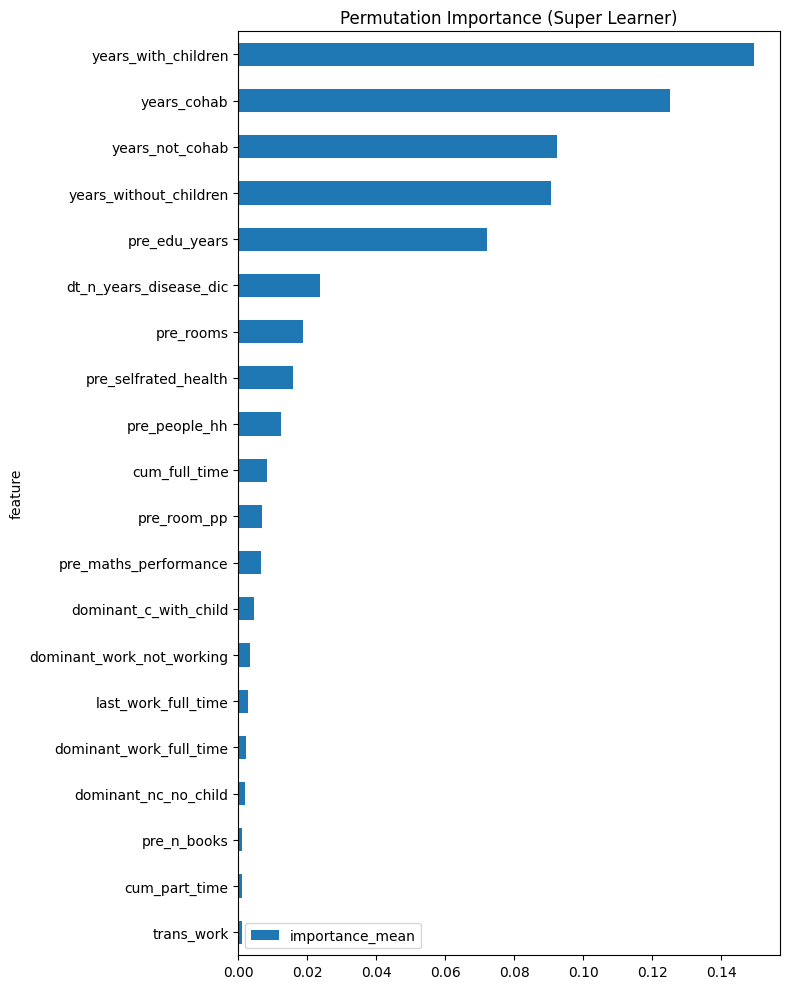

In [18]:
gc.plot_super_learner_permutation_importance(X = X_med_features_depress_65_75_dic, 
                                             y = y_depress_med_65_75_dic, 
                                             model = y_depress_med_super_learner, 
                                             feature_names = trt_features_med_depress_65_75_dic.columns.tolist(), 
                                             label = "depress 65-75 (med)", output_dir="model_outputs/depress/med")


=== Permutation Importance (Super Learner) ===
                   feature  importance_mean  importance_std
5   years_without_children         0.106607        0.004155
3          years_not_cohab         0.092148        0.007027
4      years_with_children         0.069540        0.003570
2              years_cohab         0.066654        0.005745
30  dt_n_years_disease_dic         0.039582        0.002767
33    pre_selfrated_health         0.011354        0.002356
42   pre_maths_performance         0.010930        0.002287
32     pre_ch_n_child_cond         0.010454        0.001673
45             pre_migrant         0.010078        0.002691
40             pre_n_books         0.007517        0.001767
13   dominant_c_with_child         0.005616        0.001001
47              pre_dad_hs         0.005241        0.001013
16          first_fulltime         0.003591        0.000864
15             trans_cohab         0.003480        0.001364
36            pre_hospital         0.003149        0

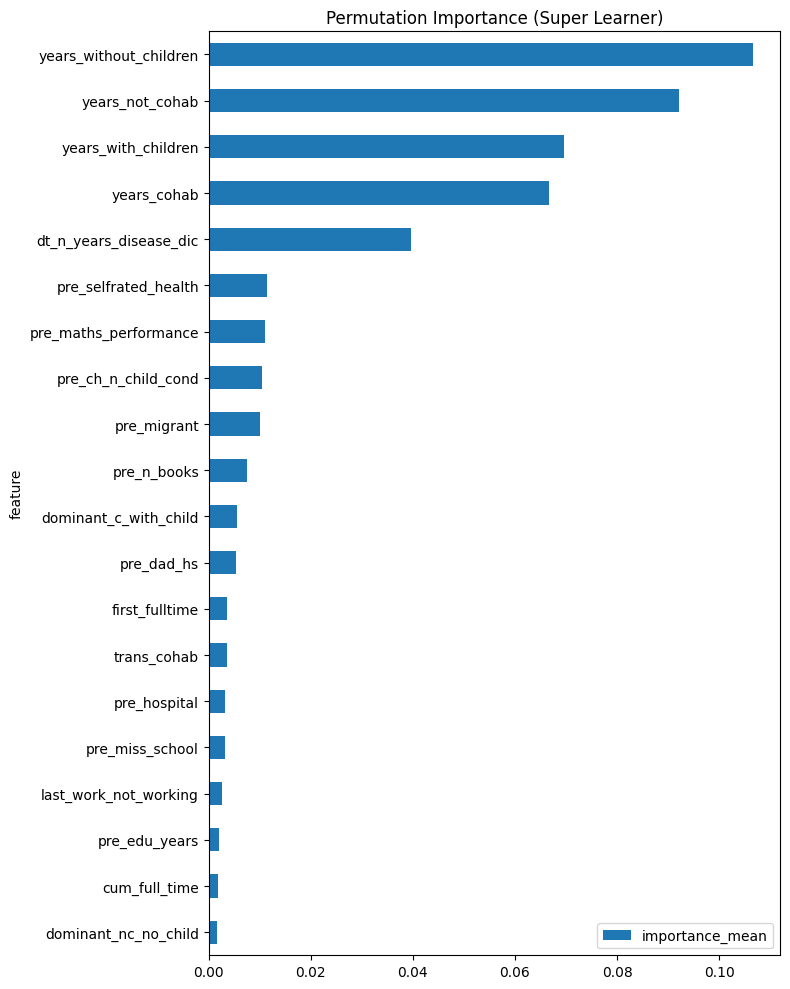

In [19]:
gc.plot_super_learner_permutation_importance(X = X_cor_features_depress_65_75_dic, 
                                             y = y_depress_cor_65_75_dic, 
                                             model = y_depress_cor_super_learner, 
                                             feature_names = trt_features_cor_depress_65_75_dic.columns.tolist(), 
                                             label = "depress 65-75 (cor)", output_dir="model_outputs/depress/cor")


=== Permutation Importance (Super Learner) ===
                      feature  importance_mean  importance_std
3             years_not_cohab         0.106210        0.004648
5      years_without_children         0.104969        0.007740
4         years_with_children         0.092509        0.005930
2                 years_cohab         0.076788        0.005289
0               cum_full_time         0.023563        0.003382
33       pre_selfrated_health         0.021944        0.004486
42      pre_maths_performance         0.021025        0.005283
37                  pre_rooms         0.020114        0.004870
20        last_work_full_time         0.010873        0.002344
32        pre_ch_n_child_cond         0.010596        0.005372
30     dt_n_years_disease_dic         0.009431        0.004045
38              pre_people_hh         0.006560        0.002312
43       pre_lang_performance         0.005726        0.002705
27    last_cohab_c_with_child         0.004530        0.002353
19     

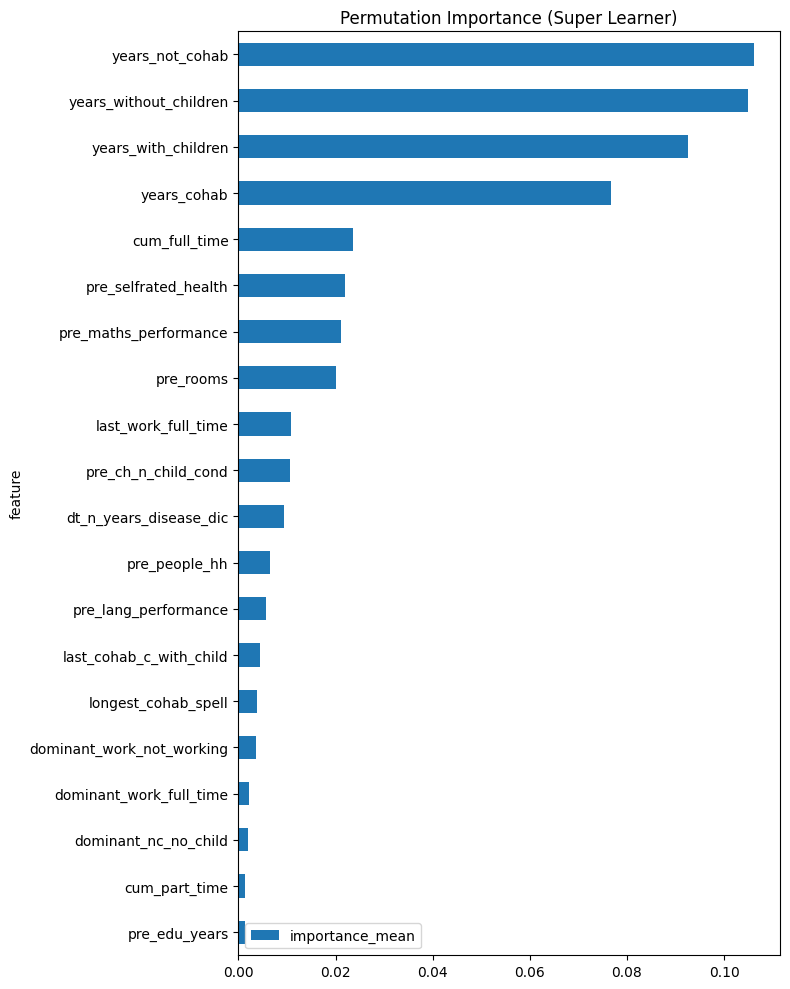

In [20]:
gc.plot_super_learner_permutation_importance(X = X_scan_features_depress_65_75_dic, 
                                             y = y_depress_scan_65_75_dic, 
                                             model = y_depress_scan_super_learner, 
                                             feature_names = trt_features_scan_depress_65_75_dic.columns.tolist(), 
                                             label = "depress 65-75 (scan)", output_dir="model_outputs/depress/scan")